In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Indian_Extent = pd.read_excel(filepath, sheet_name='Indian-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Indian_Extent)
fp.date_time(Indian_Extent)

,Extent,Date
0,376618.799,1979-01-01
1,211788.726,1979-02-01
2,262868.141,1979-03-01
3,698377.304,1979-04-01
4,1252407.727,1979-05-01
...,...,...
533,1520776.003,2023-06-01
534,2076164.165,2023-07-01
535,2731799.027,2023-08-01
536,3179384.692,2023-09-01


In [5]:
scaler = MinMaxScaler()
Indian_Extent['Extent'] = scaler.fit_transform(Indian_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 11
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Indian_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((516, 12, 1), (516,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Indian_model_LT11/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 29s 383ms/step - loss: 0.2385 - root_mean_squared_error: 0.4883 - val_loss: 0.1406 - val_root_mean_squared_error: 0.3749
Epoch 2/50
53/53 [==============================] - 18s 353ms/step - loss: 0.1150 - root_mean_squared_error: 0.3392 - val_loss: 0.0830 - val_root_mean_squared_error: 0.2881
Epoch 3/50
53/53 [==============================] - 18s 339ms/step - loss: 0.0759 - root_mean_squared_error: 0.2754 - val_loss: 0.0545 - val_root_mean_squared_error: 0.2335
Epoch 4/50
53/53 [==============================] - 19s 372ms/step - loss: 0.0428 - root_mean_squared_error: 0.2070 - val_loss: 0.0266 - val_root_mean_squared_error: 0.1632
Epoch 5/50
53/53 [==============================] - 19s 367ms/step - loss: 0.0230 - root_mean_squared_error: 0.1515 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1175
Epoch 6/50
53/53 [==============================] - 19s 362ms/step - loss: 0.0171 - root_mean_squared_error: 0.1309 - val_loss: 0.0099 

53/53 [==============================] - 19s 365ms/step - loss: 0.0048 - root_mean_squared_error: 0.0691 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0459
Epoch 33/50
53/53 [==============================] - 4s 82ms/step - loss: 0.0049 - root_mean_squared_error: 0.0696 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0676
Epoch 34/50
53/53 [==============================] - 22s 416ms/step - loss: 0.0051 - root_mean_squared_error: 0.0717 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0435
Epoch 35/50
53/53 [==============================] - 4s 68ms/step - loss: 0.0042 - root_mean_squared_error: 0.0645 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0440
Epoch 36/50
53/53 [==============================] - 3s 62ms/step - loss: 0.0041 - root_mean_squared_error: 0.0640 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0641
Epoch 37/50
53/53 [==============================] - 3s 53ms/step - loss: 0.0051 - root_mean_squared_error: 0.0713 - val_loss: 0.0027 - val_root_mea

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

8.776424753665925 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

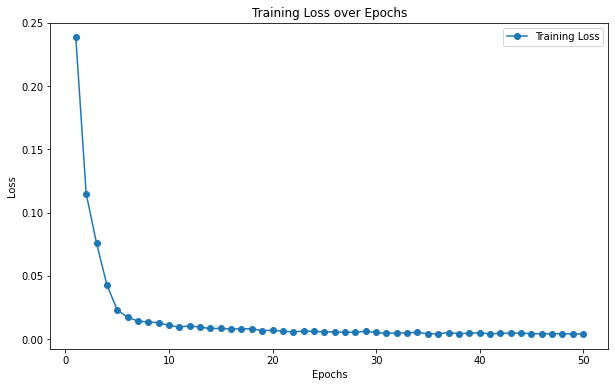

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

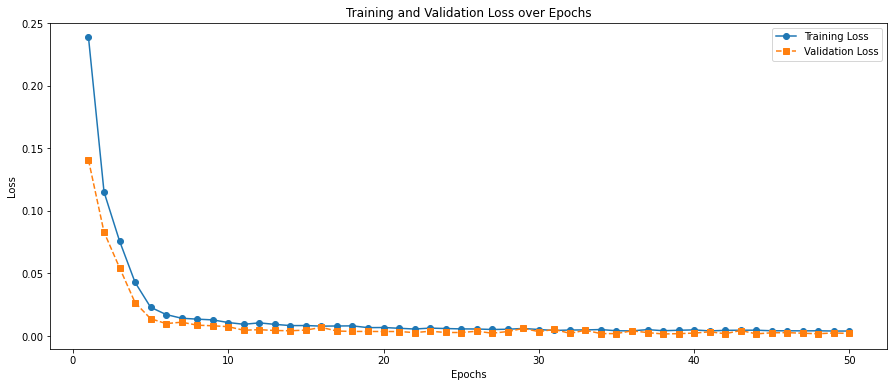

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Indian_model_LT11/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 16ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.04525923216529664
MAE : 0.03670291879443953


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,1.809775e+05,444914.605
1,5.307790e+05,827036.916
2,1.131338e+06,1142021.216
3,1.824010e+06,1885693.654
4,2.490632e+06,2542569.663
5,3.153516e+06,3107373.845
6,3.606068e+06,3488175.444
7,3.546511e+06,3746306.528
8,2.888054e+06,2942322.822
9,1.646740e+06,1507212.955


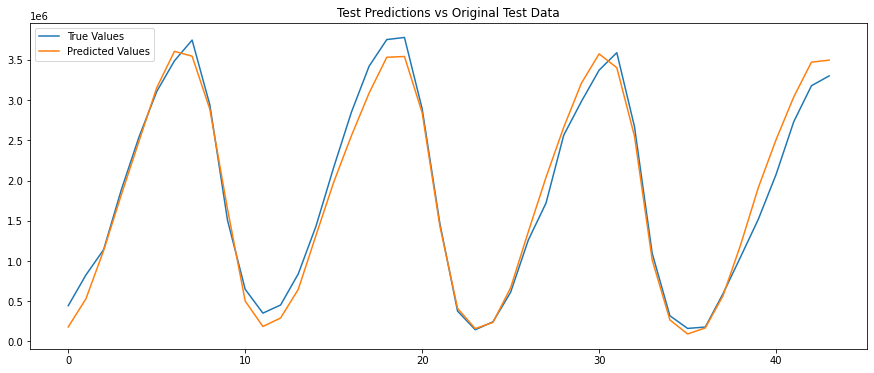

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 22ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

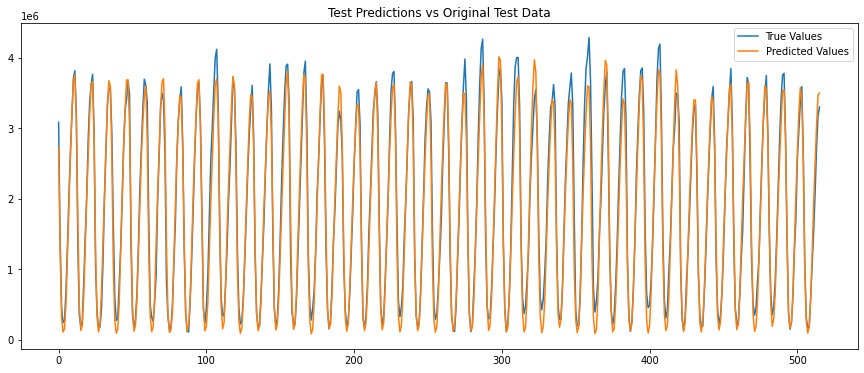

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()